In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
from multiprocessing import Pool
sc.settings.verbosity = 1

#sc.logging.print_versions()

import os 
import sys
import gc
import importlib

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
sns.set_style('white', {'axes.grid' : False})

sys.path.append('/home/lee/project/scanpy_func/')

import scanpy_func as sf

def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

# GSE200997

In [2]:
df = pd.read_csv('GSE200997_GEO_processed_CRC_10X_raw_UMI_count_matrix.csv.gz', compression='gzip')

In [3]:
df.index = df['Unnamed: 0'].values
df = df.drop('Unnamed: 0', axis=1)

In [4]:
adata = sc.AnnData(df.T)
adata

AnnData object with n_obs × n_vars = 49859 × 23828

In [5]:
meta = pd.read_csv('GSE200997_GEO_processed_CRC_10X_cell_annotation.csv.gz', compression='gzip', index_col=0)
adata.obs = meta

In [6]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

normalizing counts per cell
    finished (0:00:04)


AnnData object with n_obs × n_vars = 49859 × 23828
    obs: 'samples', 'Condition', 'Location', 'MSI_Status', 'bulk_prediction', 'prediction'
    uns: 'log1p'

In [4]:
adata.write('GSE200997.h5ad')

In [9]:
adata = sc.read_h5ad('GSE200997.h5ad')

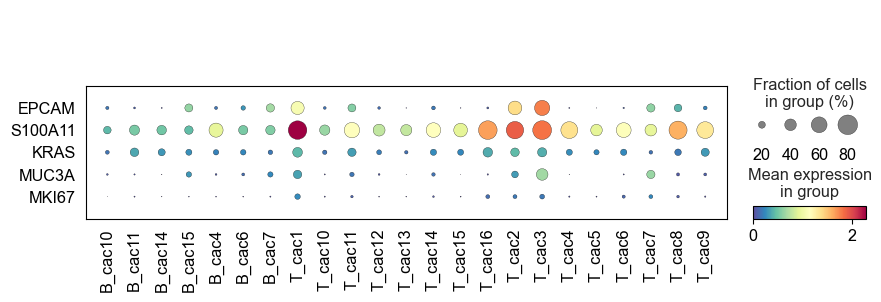

In [17]:
sc.pl.dotplot(adata, var_names=['EPCAM', 'S100A11', 'KRAS', 'MUC3A', 'MKI67'], groupby='samples', cmap='Spectral_r', swap_axes=True, save='GSE200997.pdf')

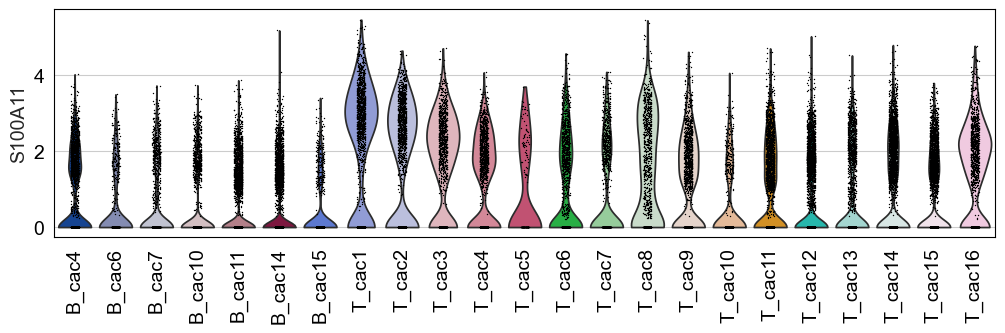

In [16]:
with rc_context(rc={'figure.figsize': (10, 3)}):
    sc.pl.violin(adata, keys='S100A11', groupby='samples', rotation=90, save='GSE200997.pdf')

extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
2548


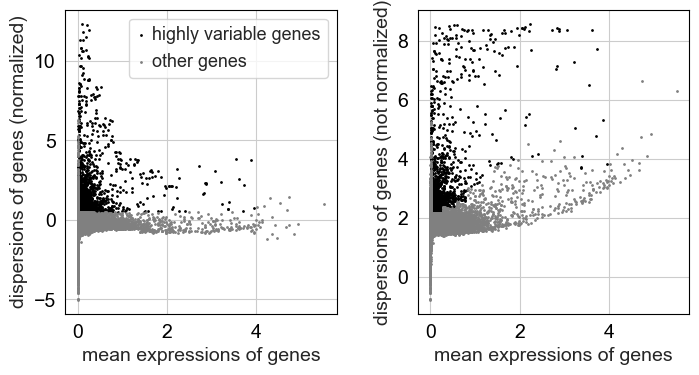

In [10]:
min_disp=0.5
min_mean=0.01
max_mean=4

sc.pp.highly_variable_genes(adata, flavor="seurat", min_disp=min_disp, min_mean=min_mean, max_mean=max_mean)
print(adata.var['highly_variable'].sum())
sc.pl.highly_variable_genes(adata)
adata.var['hvg_together'] = adata.var['highly_variable'].copy()

In [11]:
adata.raw = adata

In [12]:
adata = adata[:, adata.var['highly_variable']]

/home/lee/miniconda3/envs/rapids/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:961: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    with n_comps=50
    finished (0:00:11)


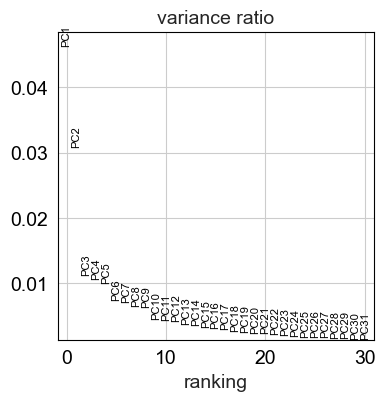

In [13]:
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pl.pca_variance_ratio(adata)

In [24]:
# sc.external.pp.harmony_integrate(adata, key='samples')

# n_neighbors=40
# n_pcs=15
res=0.2

# sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X_pca_harmony')

# sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=res)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:47)


<Figure size 250x300 with 0 Axes>

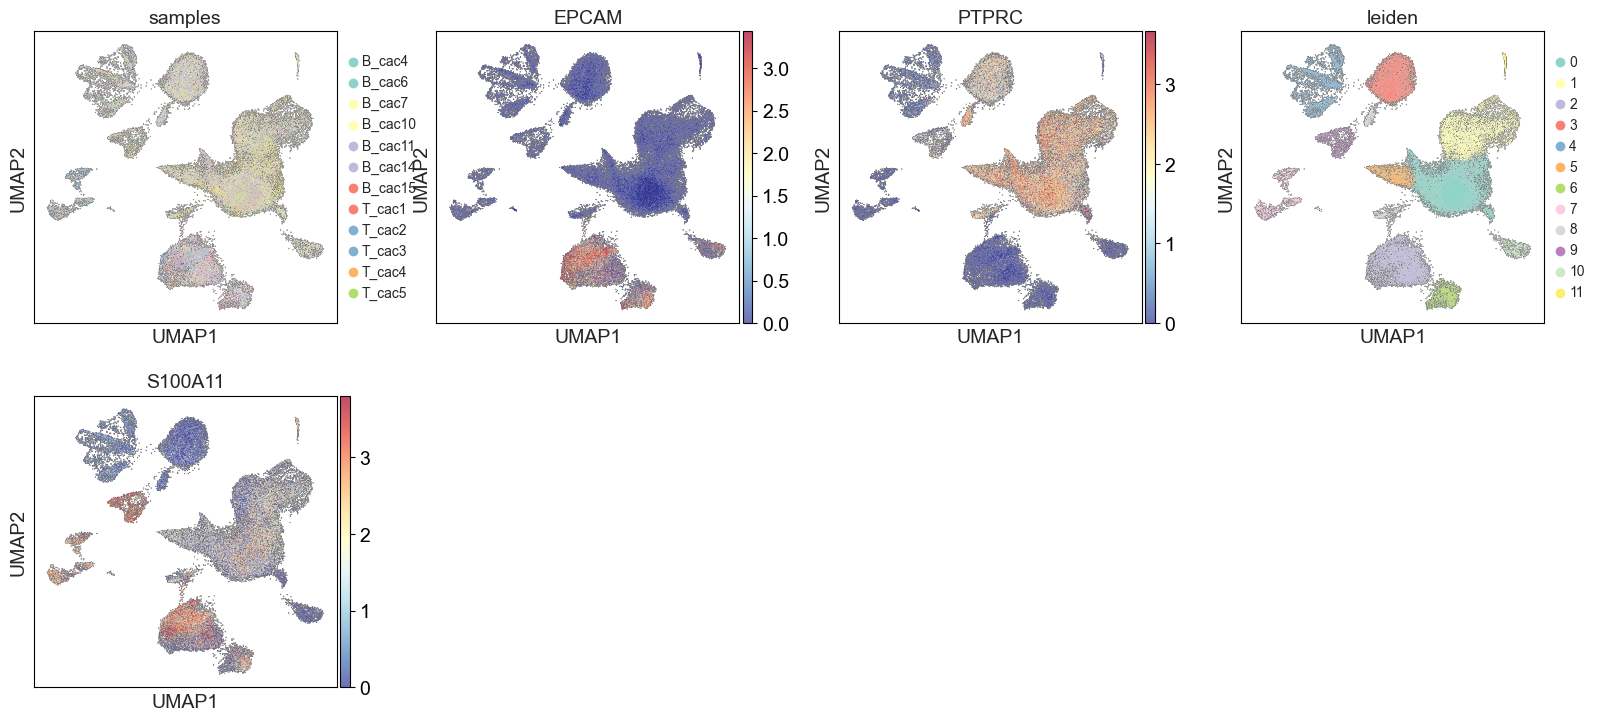

In [32]:
plt.figure(figsize=(5, 6))
sc.pl.umap(
    adata,
    color=['samples', 'EPCAM', 'PTPRC', 'leiden', 'S100A11'],
    add_outline=True,
    legend_fontsize=10,
    legend_fontoutline=5,
    palette='Set3',
    cmap='RdYlBu_r',
    frameon=True,
    size=1,
    vmax='p99', save='GSE200997_cluster.pdf'
)

In [29]:
adata.obs['type'] = 'other'
adata.obs.loc[adata.obs['leiden'].isin(['2', '6']), 'type'] = 'Epithelial cells'

<Figure size 250x300 with 0 Axes>

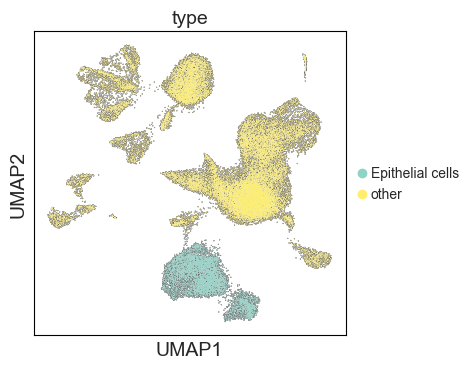

In [33]:
plt.figure(figsize=(5, 6))
sc.pl.umap(
    adata,
    color=['type'],
    add_outline=True,
    legend_fontsize=10,
    legend_fontoutline=5,
    palette='Set3',
    cmap='RdYlBu_r',
    frameon=True,
    size=1,
    vmax='p99', save='GSE200997_cluster2.pdf'
)

In [34]:
sub = adata[adata.obs['type']=='Epithelial cells']


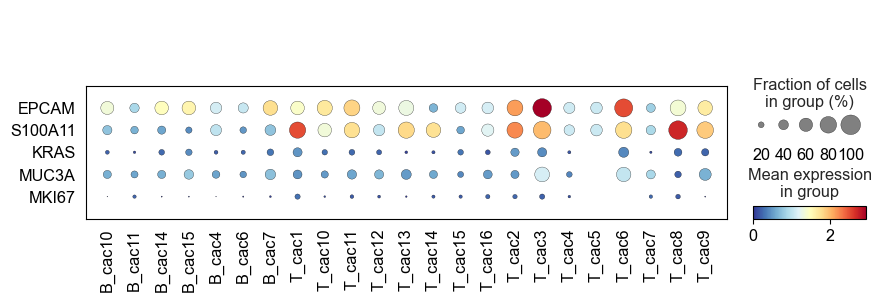

In [38]:
sc.pl.dotplot(sub, var_names=['EPCAM', 'S100A11', 'KRAS', 'MUC3A', 'MKI67'], groupby='samples', cmap='RdYlBu_r', swap_axes=True, save='GSE200997.pdf')

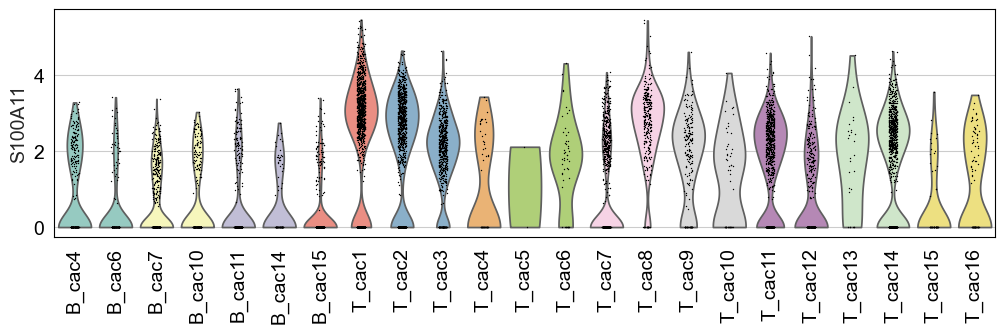

In [36]:
with rc_context(rc={'figure.figsize': (10, 3)}):
    sc.pl.violin(sub, keys='S100A11', groupby='samples', rotation=90, save='GSE200997.pdf')

# GSE132465

In [4]:
meta = pd.read_csv('GSE132465_GEO_processed_CRC_10X_cell_annotation.txt.gz', sep='\t', compression='gzip', index_col=0)
meta

,Patient,Class,Sample,Cell_type,Cell_subtype
Index,,,,,
SMC01-T_AAACCTGCATACGCCG,SMC01,Tumor,SMC01-T,Epithelial cells,CMS2
SMC01-T_AAACCTGGTCGCATAT,SMC01,Tumor,SMC01-T,Epithelial cells,CMS2
SMC01-T_AAACCTGTCCCTTGCA,SMC01,Tumor,SMC01-T,Epithelial cells,CMS2
SMC01-T_AAACGGGAGGGAAACA,SMC01,Tumor,SMC01-T,Epithelial cells,CMS2
SMC01-T_AAACGGGGTATAGGTA,SMC01,Tumor,SMC01-T,Epithelial cells,CMS2
...,...,...,...,...,...
SMC10-N_TCAGCTCGTAGCGTCC,SMC10,Normal,SMC10-N,Mast cells,Mast cells
SMC10-N_TGACTAGCAGACGCAA,SMC10,Normal,SMC10-N,Mast cells,Mast cells
SMC10-N_TGCTACCGTCTCCATC,SMC10,Normal,SMC10-N,Mast cells,Mast cells


In [3]:
df = pd.read_csv('GSE132465_GEO_processed_CRC_10X_raw_UMI_count_matrix.txt.gz', sep='\t', index_col=0)
df

,SMC01-T_AAACCTGCATACGCCG,SMC01-T_AAACCTGGTCGCATAT,SMC01-T_AAACCTGTCCCTTGCA,SMC01-T_AAACGGGAGGGAAACA,SMC01-T_AAACGGGGTATAGGTA,SMC01-T_AAAGATGAGGCCGAAT,SMC01-T_AAAGATGCATGGATGG,SMC01-T_AAAGATGTCACGACTA,SMC01-T_AAAGATGTCCGTTGCT,SMC01-T_AAAGCAACAGTCGATT,...,SMC10-N_GCCAAATAGGATGCGT,SMC10-N_GGTGAAGAGCTAGCCC,SMC10-N_GTATCTTGTAACGCGA,SMC10-N_GTGGGTCGTCCAACTA,SMC10-N_TAAGCGTGTCATCGGC,SMC10-N_TCAGCTCGTAGCGTCC,SMC10-N_TGACTAGCAGACGCAA,SMC10-N_TGCTACCGTCTCCATC,SMC10-N_TTTATGCAGTGTCTCA,SMC10-N_TTTGGTTAGTGCCATT
Index,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
A1BG-AS1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
A1CF,0,2,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A2M-AS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZZ3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bP-21264C1.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bP-2171C21.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
adata = sc.AnnData(df.T)
adata.obs = meta

In [14]:
import scipy.sparse as sps
adata.X = sps.csr_matrix(adata.X)

In [34]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:03)


In [24]:
adata.obs['Cell_type'].unique()

['Epithelial cells', 'Stromal cells', 'Myeloids', 'T cells', 'B cells', 'Mast cells']
Categories (6, object): ['B cells', 'Epithelial cells', 'Mast cells', 'Myeloids', 'Stromal cells', 'T cells']

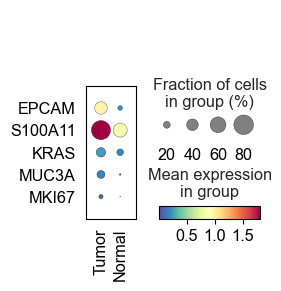

In [36]:
sc.pl.dotplot(adata, var_names=['EPCAM', 'S100A11', 'KRAS', 'MUC3A', 'MKI67'], groupby='Class', cmap='Spectral_r', swap_axes=True, )

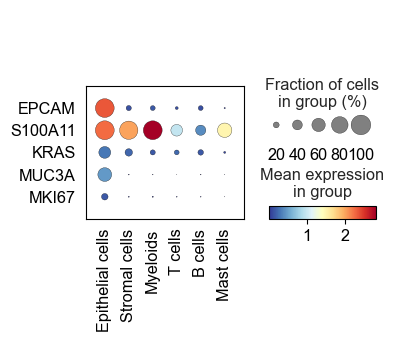

In [7]:
sc.pl.dotplot(adata, var_names=['EPCAM', 'S100A11', 'KRAS', 'MUC3A', 'MKI67'], groupby='Cell_type', cmap='RdYlBu_r', swap_axes=True, save='cell_type.pdf')

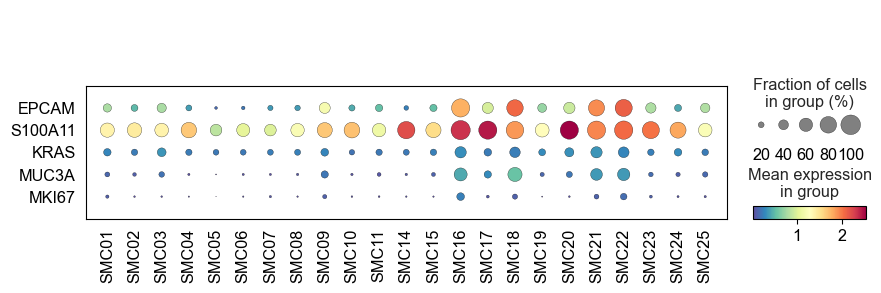

In [60]:
sc.pl.dotplot(adata, var_names=['EPCAM', 'S100A11', 'KRAS', 'MUC3A', 'MKI67'], groupby='Patient', cmap='Spectral_r', swap_axes=True, save='patiant.pdf')

In [23]:
adata.obs[['Patient', 'Class']].drop_duplicates()

,Patient,Class
Index,,
SMC01-T_AAACCTGCATACGCCG,SMC01,Tumor
SMC02-T_AAACGGGTCTGCCAGG,SMC02,Tumor
SMC03-T_AAACCTGGTTGCCTCT,SMC03,Tumor
SMC04-T_AAACCTGCAGGTCTCG,SMC04,Tumor
SMC05-T_CCACTACCATTGTGCA,SMC05,Tumor
SMC06-T_AAAGTAGGTTCCCTTG,SMC06,Tumor
SMC07-T_AAAGATGCATTCCTGC,SMC07,Tumor
SMC08-T_AAACGGGCATGCCTTC,SMC08,Tumor
SMC09-T_AAACCTGAGAAACCTA,SMC09,Tumor


In [30]:
adata.obs['patient_sample'] = adata.obs['Patient'].astype(str) + '_' + adata.obs['Class'].astype(str)

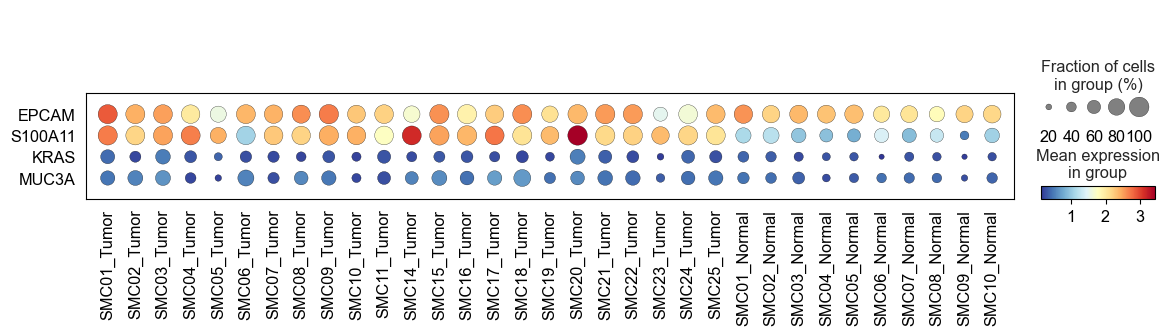

In [8]:
sc.pl.dotplot(adata[adata.obs['Cell_type']=='Epithelial cells'], var_names=['EPCAM', 'S100A11', 'KRAS', 'MUC3A'], groupby='patient_sample', cmap='RdYlBu_r', swap_axes=True, save='GSE132465.pdf')

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
3435


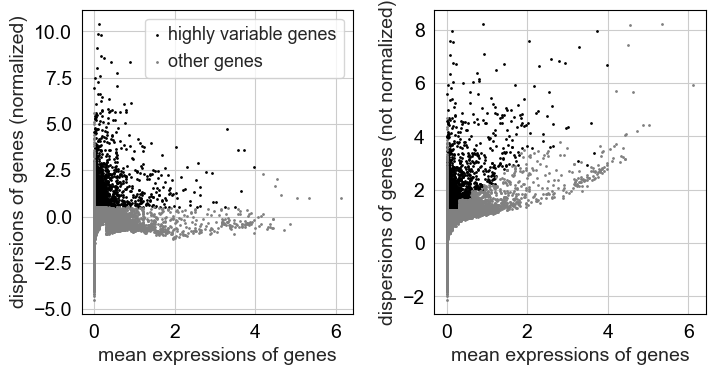

In [43]:
min_disp=0.5
min_mean=0.01
max_mean=4

sc.pp.highly_variable_genes(adata, flavor="seurat", min_disp=min_disp, min_mean=min_mean, max_mean=max_mean)
print(adata.var['highly_variable'].sum())
sc.pl.highly_variable_genes(adata)
adata.var['hvg_together'] = adata.var['highly_variable'].copy()

In [44]:
adata.raw = adata

In [45]:
adata = adata[:, adata.var['highly_variable']]

/home/lee/miniconda3/envs/rapids/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:961: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:37)


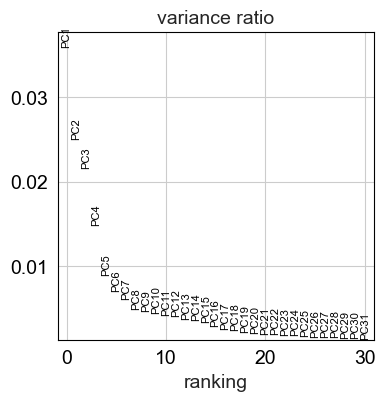

In [46]:
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pl.pca_variance_ratio(adata)

In [54]:
sc.external.pp.harmony_integrate(adata, key='patient_sample')

n_neighbors=40
n_pcs=15
res=0.5

sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X_pca_harmony')

sc.tl.umap(adata)


2024-07-30 18:51:56,209 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-07-30 18:52:05,303 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-07-30 18:52:05,757 - harmonypy - INFO - Iteration 1 of 10
2024-07-30 18:52:41,704 - harmonypy - INFO - Iteration 2 of 10
2024-07-30 18:53:15,850 - harmonypy - INFO - Iteration 3 of 10
2024-07-30 18:53:49,105 - harmonypy - INFO - Iteration 4 of 10
2024-07-30 18:54:19,407 - harmonypy - INFO - Iteration 5 of 10
2024-07-30 18:54:51,903 - harmonypy - INFO - Iteration 6 of 10
2024-07-30 18:55:05,562 - harmonypy - INFO - Iteration 7 of 10
2024-07-30 18:55:20,825 - harmonypy - INFO - Iteration 8 of 10
2024-07-30 18:55:35,244 - harmonypy - INFO - Converged after 8 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:29)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:11)


In [ ]:
# adata.write('GSE132465.h5ad')
adata = sc.read_h5ad('GSE132465.h5ad')

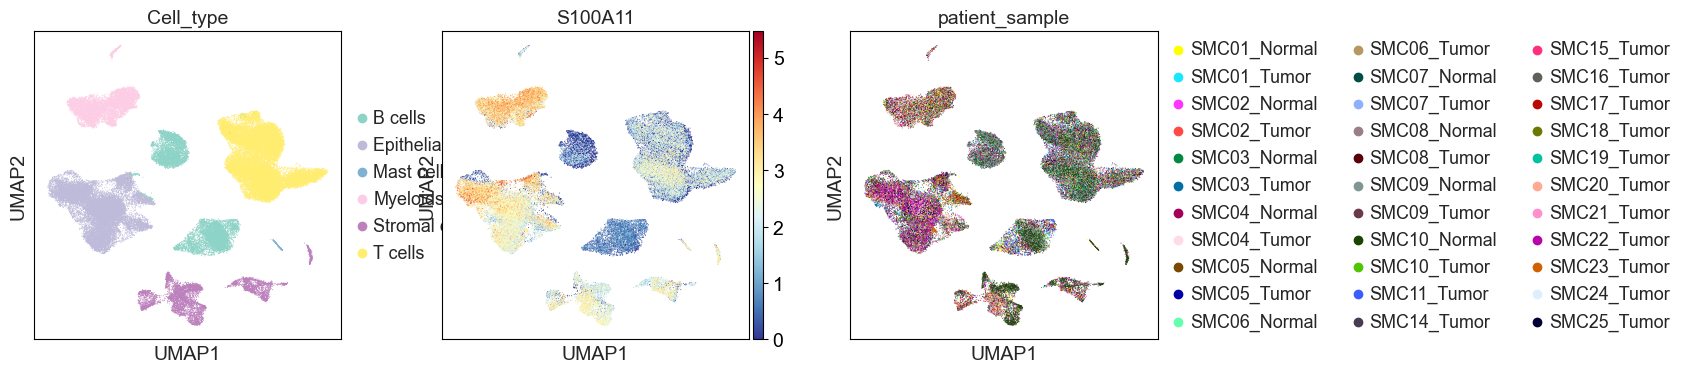

In [6]:
sc.pl.umap(adata, color=['Cell_type', 'S100A11', 'patient_sample'], cmap='RdYlBu_r', save='cluster.pdf')

<Figure size 250x300 with 0 Axes>

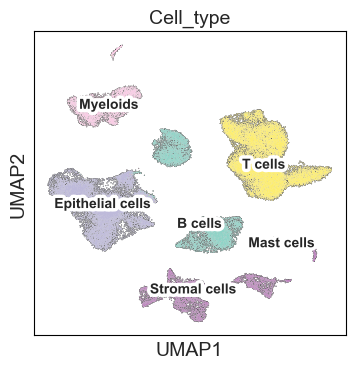

In [68]:
plt.figure(figsize=(5, 6))
sc.pl.umap(
    adata,
    color=['Cell_type'],
    add_outline=True,
    legend_loc='on data',
    legend_fontsize=10,
    legend_fontoutline=5,
    palette='Set3',
    frameon=True,
    size=1,
    save='GSE132465_cluster.pdf'
)
